# **Milestone 1**

##**Context**
 
 - Why is this problem important to solve?
As the human population increases, energy demands will similarly increase. Identifying the consumption trends of the most polluting sources of energy will be crucial going forward with recalibrating our energy needs to curtail global warming.

##**Objective**

 - What is the intended goal?
The objective of this analysis is twofold; first, identify the best and worst-polluting energy sources by volume--not just efficiency--such that efforts can reprioritize efforts to reduce energy demands from the highest polluting energy sources. 

Our objective is to forecast the carbon emissions for natural gas fuel for the next 12 months and propose measures that can be adopted as policies to reduce these emissions. 

##**Key questions**

- What are the key questions that need to be answered?

0. How have energy demands increased
1. What are the highest polluting energy sources
2. What are the lowest
3. Which energy sources have been trending up in recent history



##**Problem Formulation**:

- What is it that we are trying to solve using data science?
We are trying to forecast the emissions for natural gas in order to determine future carbon emissions. 

##**Attributes Information:**

This datset is the past monthly data of Carbon dioxide emissions from electricity generation from the US Energy Information Administration categorized by fuel type such as Coal, Natural gas etc.

**MSN:-** Reference to Mnemonic Series Names (U.S. Energy Information Administration Nomenclature)

**YYYYMM:-** The month of the year on which these emissions were observed

**Value:-** Amount of CO2 Emissions in Million Metric Tons of Carbon Dioxide

**Description:-**  Different category of electricity production through which carbon is emissioned.

## **Important Notes**

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise. 

- In the notebook, there are markdown cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques. 

###**Loading the libraries**

In [2]:
# It is recommended to upgrade the statsmodels library. 
# Uncomment the below code to upgrade statsmodels
!pip install statsmodels --upgrade

In [3]:
#Import basic libraries
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


###**Loading the data**

In [4]:
df = pd.read_excel('MER_T12_06.xlsx')
df.head()

MSN  YYYYMM   Value                               Description
0  CLEIEUS  197301  72.076  Coal Electric Power Sector CO2 Emissions
1  CLEIEUS  197302  64.442  Coal Electric Power Sector CO2 Emissions
2  CLEIEUS  197303  64.084  Coal Electric Power Sector CO2 Emissions
3  CLEIEUS  197304  60.842  Coal Electric Power Sector CO2 Emissions
4  CLEIEUS  197305  61.798  Coal Electric Power Sector CO2 Emissions

In [5]:
#to ignore warnings
import warnings
import itertools
warnings.filterwarnings("ignore")

In [6]:
#conversion of "YYYYMM" columnn into standard datetime format & making it as index
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_excel('MER_T12_06.xlsx', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df.head(15)

MSN    Value                               Description
YYYYMM                                                                
1973-01-01  CLEIEUS   72.076  Coal Electric Power Sector CO2 Emissions
1973-02-01  CLEIEUS   64.442  Coal Electric Power Sector CO2 Emissions
1973-03-01  CLEIEUS   64.084  Coal Electric Power Sector CO2 Emissions
1973-04-01  CLEIEUS   60.842  Coal Electric Power Sector CO2 Emissions
1973-05-01  CLEIEUS   61.798  Coal Electric Power Sector CO2 Emissions
1973-06-01  CLEIEUS   66.538  Coal Electric Power Sector CO2 Emissions
1973-07-01  CLEIEUS   72.626  Coal Electric Power Sector CO2 Emissions
1973-08-01  CLEIEUS   75.181  Coal Electric Power Sector CO2 Emissions
1973-09-01  CLEIEUS   68.397  Coal Electric Power Sector CO2 Emissions
1973-10-01  CLEIEUS   67.668  Coal Electric Power Sector CO2 Emissions
1973-11-01  CLEIEUS   67.021  Coal Electric Power Sector CO2 Emissions
1973-12-01  CLEIEUS   71.118  Coal Electric Power Sector CO2 Emissions
NaT         CLEIEUS  811.791  Coal Electric Power Sector CO2 Emissions
1974-01-01  CLEIEUS    70.55  Coal Electric Power Sector CO2 Emissions
1974-02-01  CLEIEUS   62.929  Coal Electric Power Sector CO2 Emissions

**The arguments can be explained as:**

- **parse_dates:** This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
- **index_col:** This is a key that forces pandas to use the date time column as index.
- **date_parser:** Converts an input string into datetime variable.

- Let us first identify and **drop the non datetimeindex** rows. First, let's convert the index to datetime, coerce errors, and filter NaT

In [7]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).filter('NaT').values]
ts.head()

Empty DataFrame
Columns: []
Index: [1973-01-01 00:00:00, 1973-02-01 00:00:00, 1973-03-01 00:00:00, 1973-04-01 00:00:00, 1973-05-01 00:00:00]

In [8]:
#Check the datatypes of each column. Hint: Use dtypes method
df.dtypes

MSN            object
Value          object
Description    object
dtype: object

**Observation**
Despite being numeric, Value is stored as an object. Good to convert that so we can actually treat it as a continuous numeric field.

In [9]:
#convert the emision value into numeric value
df['Value'] = pd.to_numeric(df['Value'])

ValueError: Unable to parse string "Not Available" at position 3396

**Additional Observations**
We can see *why* Value is not numeric; it has string values of 'Not Available' where there is no data. (see below at position 3396) Let's convert this to numpy's NaN which is of float type, and then try again. 

In [10]:
df.iloc[3396]

MSN                                                      GEEIEUS
Value                                              Not Available
Description    Geothermal Energy Electric Power Sector CO2 Em...
Name: 1973-01-01 00:00:00, dtype: object

In [11]:
#convert the emision value into numeric value Take 2
df = df.replace('Not Available', np.NaN)
df['Value'] = pd.to_numeric(df['Value'])

In [12]:
#Check total number of missing values of each column. Hint: Use isnull() method
df.isnull().sum()

MSN              0
Value          416
Description      0
dtype: int64

In [13]:
#Drop the missing value using dropna(inplace = True)
df = df.dropna()

In [14]:
df

MSN    Value                                       Description
YYYYMM                                                                        
1973-01-01  CLEIEUS   72.076          Coal Electric Power Sector CO2 Emissions
1973-02-01  CLEIEUS   64.442          Coal Electric Power Sector CO2 Emissions
1973-03-01  CLEIEUS   64.084          Coal Electric Power Sector CO2 Emissions
1973-04-01  CLEIEUS   60.842          Coal Electric Power Sector CO2 Emissions
1973-05-01  CLEIEUS   61.798          Coal Electric Power Sector CO2 Emissions
...             ...      ...                                               ...
2016-03-01  TXEIEUS  115.997  Total Energy Electric Power Sector CO2 Emissions
2016-04-01  TXEIEUS  113.815  Total Energy Electric Power Sector CO2 Emissions
2016-05-01  TXEIEUS  129.440  Total Energy Electric Power Sector CO2 Emissions
2016-06-01  TXEIEUS  172.074  Total Energy Electric Power Sector CO2 Emissions
2016-07-01  TXEIEUS  201.958  Total Energy Electric Power Sector CO2 Emissions

[4678 rows x 3 columns]

###**Dataset visualization**

- The dataset has 8 energy sources of CO2 emission. 
- Group the CO2 Emission dataset based on the type of energy source.

In [15]:
pd.set_option('display.max_colwidth', None)
df1 = df.groupby('Description')

####**Visualize the dependency of the emission in the power generation with time.**

In [16]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']

df1 = df.groupby('Description')
df1.head()

#using a hardcoded list is labor intensive. Let's just create our own dictionary and use the replace function to
#shorten our descriptions. 

descriptions = df1['Description'].unique()
m = {}
for description in descriptions:
    m[description[0]] = ' '.join(description[0].split(' ')[0:3])

df = df.replace({"Description": m})

In [17]:
descriptions

Description
Coal Electric Power Sector CO2 Emissions                                                                                                        [Coal Electric Power Sector CO2 Emissions]
Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions    [Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions]
Geothermal Energy Electric Power Sector CO2 Emissions                                                                              [Geothermal Energy Electric Power Sector CO2 Emissions]
Natural Gas Electric Power Sector CO2 Emissions                                                                                          [Natural Gas Electric Power Sector CO2 Emissions]
Non-Biomass Waste Electric Power Sector CO2 Emissions                                                                              [Non-Biomass Waste Electric Power Sector CO2 Emissions]
Petroleum Coke Electric Power Sector CO2 Emissions   

In [18]:
df.to_csv('CO2_data_cleaned')

Description
Coal Electric Power           AxesSubplot(0.125,0.2;0.775x0.68)
Distillate Fuel, Including    AxesSubplot(0.125,0.2;0.775x0.68)
Geothermal Energy Electric    AxesSubplot(0.125,0.2;0.775x0.68)
Natural Gas Electric          AxesSubplot(0.125,0.2;0.775x0.68)
Non-Biomass Waste Electric    AxesSubplot(0.125,0.2;0.775x0.68)
Petroleum Coke Electric       AxesSubplot(0.125,0.2;0.775x0.68)
Petroleum Electric Power      AxesSubplot(0.125,0.2;0.775x0.68)
Residual Fuel Oil             AxesSubplot(0.125,0.2;0.775x0.68)
Total Energy Electric         AxesSubplot(0.125,0.2;0.775x0.68)
Name: Value, dtype: object

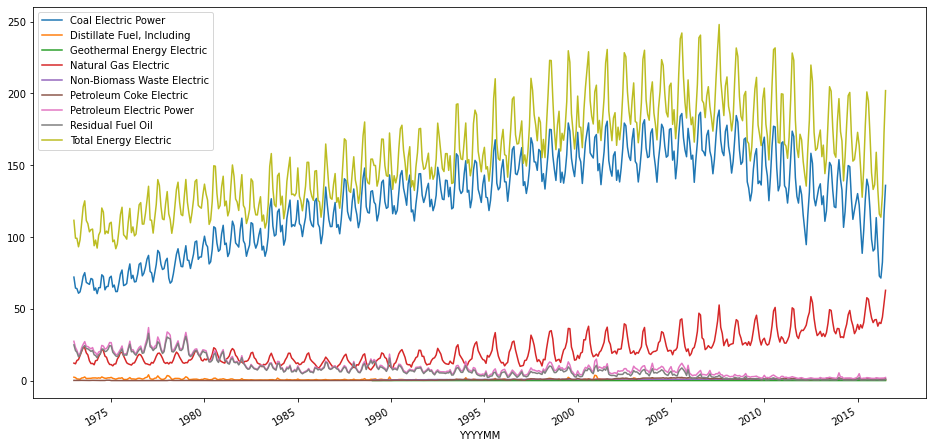

In [79]:
## Code here
plt.figure(figsize=(16,8))
df.groupby('Description')['Value'].plot(legend=True)

- **Observations and Insights: **
* Coal energy usage peaked in 2005 and has, on average, been declining since then.
* Distillate fuel usage has been similarly decreasing since 2005.
* Natural gas has been steadily rising since about 2000
* Non-biomass waste, distillate fuel, and geothermal energy are all negligibly low in recent history, after having been historically more prevalent until about 1995. 

#### **Visualize the trend of CO2 emission from each energy source individually**

<Figure size 1152x576 with 0 Axes>

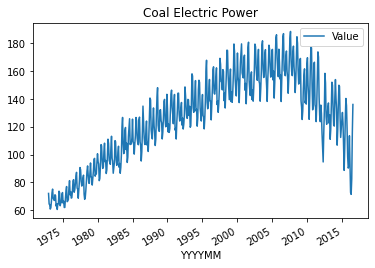

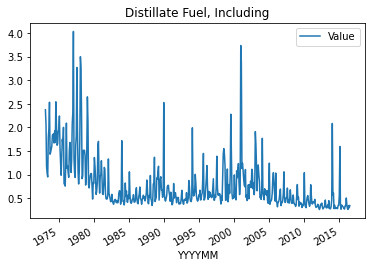

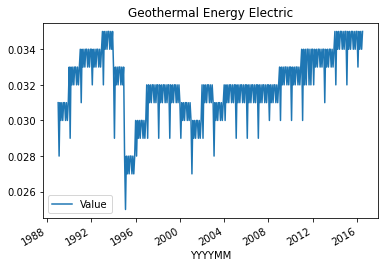

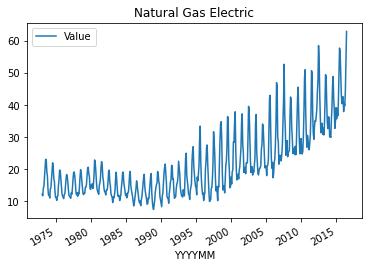

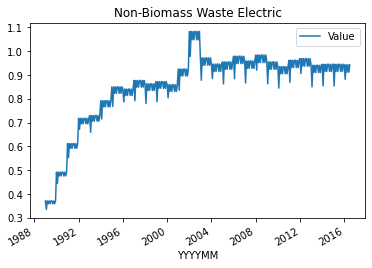

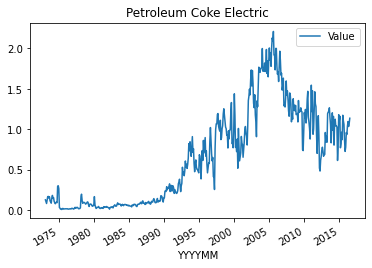

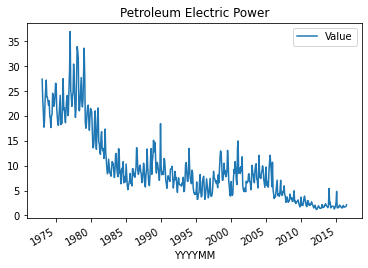

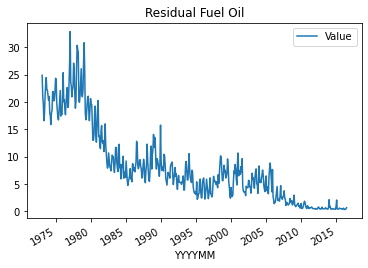

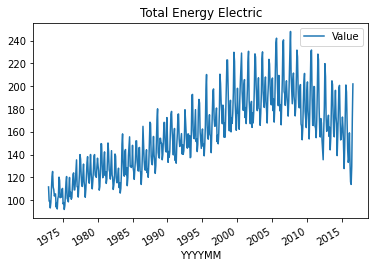

In [92]:
plt.figure(figsize=(16,8))
for title, group in df.groupby('Description'):
    group.plot(title=title)

#### **Observations and Insights: **

From our previous chart of all energy sources, it can be hard to tell how the smaller energy sources (**non-biomass waste**, **distillate fuel**, **geothermal energy**) have changed over time, as the y-axis is so large that changes are hard to detect. 

* We can see that **Non-biomass waste electric** emissions tracking started in about 1990, rapidly accelerated to 2002, and leveled off since then in terms of use. 
* **Petroleum electric power** has substantially decreased from values as high as 35 annual million metric tons of CO2 to less than 5. 
* **Residual Fuel Oil** and **Distillate Fuel** have similarly substantially decreasing trends similar to petroleum electric power. 
* **Natural Gas Electric** has actually sbustantially increased from 20 tons of emission sto up to 50 in recent history.
* It's worth noting the while geothermal energy sources don't release carbon emissions like the others, that does not mean they produce less energy; they might just be more efficient. IT would be worthwhile to look at energy per metric ton of CO2 emitted. 

####**Bar chart of CO2 Emissions per energy source**

In [93]:
CO2_per_source = df.groupby('Description')['Value'].sum().sort_values()

In [103]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']
CO2_per_source

Description
Geothermal Energy Electric        20.886
Non-Biomass Waste Electric       556.261
Petroleum Coke Electric          670.281
Distillate Fuel, Including       807.411
Residual Fuel Oil               8475.411
Petroleum Electric Power        9953.116
Natural Gas Electric           22270.917
Coal Electric Power           130880.389
Total Energy Electric         163681.569
Name: Value, dtype: float64

<AxesSubplot:xlabel='Description'>

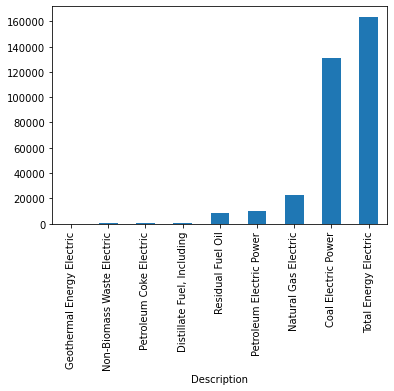

In [97]:
##Code here
CO2_per_source.plot.bar()

####**For developing the time series model and forcasting, use the natural gas CO2 emission from the electirical power generation**


In [100]:
df1 = df.iloc[:,1:]   # Monthly total emissions (mte)
df2= df1.groupby(['Description', pd.Grouper(freq="M")])['Value'].sum().unstack(level = 0)
df3 = df2['Natural Gas Electric'] # monthly total emissions (mte)
df3.head()

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
               ...  
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Name: Natural Gas Electric, Length: 523, dtype: float64

<AxesSubplot:xlabel='YYYYMM'>

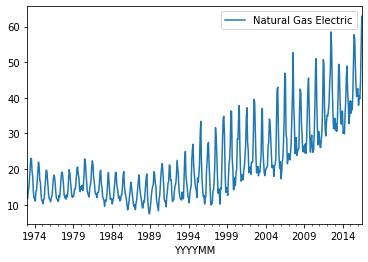

In [102]:
df3.plot(legend=True)

####**Observations & insights: **
* Natural gas is the second highest polluter of the energy sources in the US, with coal being the worst. 
* 

##**Proposed approach**

- **Potential techniques -** What different techniques should be explored?
Approach 1: By forecasting the increase in natural gas CO2 emissions and taking the integral of that line, we can create a methodology to forecast the total carbon emissions of any energy source. We can research what level of CO2 emissions the energy sector must abide by in the next few years, setting a standard for what percent of energy needs to decrease from natural gas. 
Approach 2: By taking 
- **Overall solution design -** What is the potential solution design?
While we could use an ARIMA model, that's pretty boring. I'll be using a CNN to forecast natural gas CO2 emissions. This will allow us to not have to care about stationarity, and create a more robust model that will forecast seasonal trends in addition to overall trend. 
- **Measures of success -** What are the key measures of success to compare different techniques?
